# APIM ❤️ OpenAI

## OpenAI Token Rate Limit tests

Invoke OpenAI API to test the [token rate limiting policy](https://learn.microsoft.com/azure/api-management/azure-openai-token-limit-policy). 

### Prerequisites

- [Python 3.12 or later version](https://www.python.org/) installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Python environment](https://code.visualstudio.com/docs/python/environments#_creating-environments) with the [requirements.txt](../../requirements.txt) or run `pip install -r requirements.txt` in your terminal
- [An Azure Subscription](https://azure.microsoft.com/free/) with [Contributor](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#contributor) + [RBAC Administrator](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#role-based-access-control-administrator) or [Owner](https://learn.microsoft.com/en-us/azure/role-based-access-control/built-in-roles/privileged#owner) roles
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed and [Signed into your Azure subscription](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

▶️ Click `Run All` to execute all steps sequentially, or execute them `Step by Step`...


<a id='0'></a>
### ⚙️ Initialize client tool for a given APIM service

👉 An existing Azure OpenAI API is expected to be already configured on APIM

In [ ]:
import os, sys, json, requests
sys.path.insert(1, '../shared')  # add the shared directory to the Python path
import utils
from apimtools import APIMClientTool

openai_deployment_name = "gpt-4o-mini"
openai_api_version = "2024-10-21"

apimClientTool = APIMClientTool(
    "change-me", ## specify the existing API Management resource name
    "change-me" ## specify the resource group name where the API Management resource is located
)
apimClientTool.initialize()
apimClientTool.discover_openai_api('openai')



⚙️ Running: az account show 
✅ Retrieved az account ⌚ 16:04:33.782420 :3s]
👉🏽 Current user: alexviei@microsoft.com
👉🏽 Tenant ID: 16b3c013-d300-468d-ac64-7eda0820b6d3
👉🏽 Subscription ID: 9d4a14de-67d7-4029-a3b4-7a7e3e6581cf
👉🏽 APIM Service Id: /subscriptions/9d4a14de-67d7-4029-a3b4-7a7e3e6581cf/resourceGroups/lab-token-rate-limiting/providers/Microsoft.ApiManagement/service/apim-2irczv2tuhnve
👉🏽 APIM Gateway URL: {self.apim_resource_gateway_url}
👉🏽 Retrieved key 0 for subscription: master
👉🏽 Retrieved key 1 for subscription: openai-subscription
👉🏽 Found OpenAI API with id /subscriptions/9d4a14de-67d7-4029-a3b4-7a7e3e6581cf/resourceGroups/lab-token-rate-limiting/providers/Microsoft.ApiManagement/service/apim-2irczv2tuhnve/apis/openai and path openai


<a id='requests'></a>
### 🧪 Send multiple requests to surpass the established token rate limit


In [2]:
import requests

url = apimClientTool.apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version

messages={"messages":[
    {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
    {"role": "user", "content": "Can you tell me the time, please?"}
]}

api_runs = []
for i in range(10):
    response = requests.post(url, headers = {'api-key':apimClientTool.apim_subscriptions[1].get("key")}, json = messages)
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  Oh sure, let me just reach through the screen and check the time. Spoiler: I can't! But hey, if you have a clock or a phone, you could totally check that yourself. Crazy, right?
▶️ Run:  2 status code:  200 ✅
💬  Sure! Just look at your phone or a clock. That way, you can avoid the disappointment of my not-so-glorious time-telling abilities.
▶️ Run:  3 status code:  200 ✅
💬  Oh sure, because I'm clearly sitting here with a clock right in front of me. If only I could magically tell time without actually being able to see it. How about you check your own watch or phone? Just a thought!
▶️ Run:  4 status code:  200 ✅
💬  Oh sure, let me just check my time machine. But since that's not a thing, I'm afraid you’re on your own with that one!
▶️ Run:  5 status code:  200 ✅
💬  Oh sure, let me just pull out my magical time-telling device. Just kidding! Why don't you check your own phone or watch? They do wonders for that sort of thing.
▶️ Run:  6 status code:  200

<a id='plot'></a>
### 🔍 Analyze Token Rate limiting results


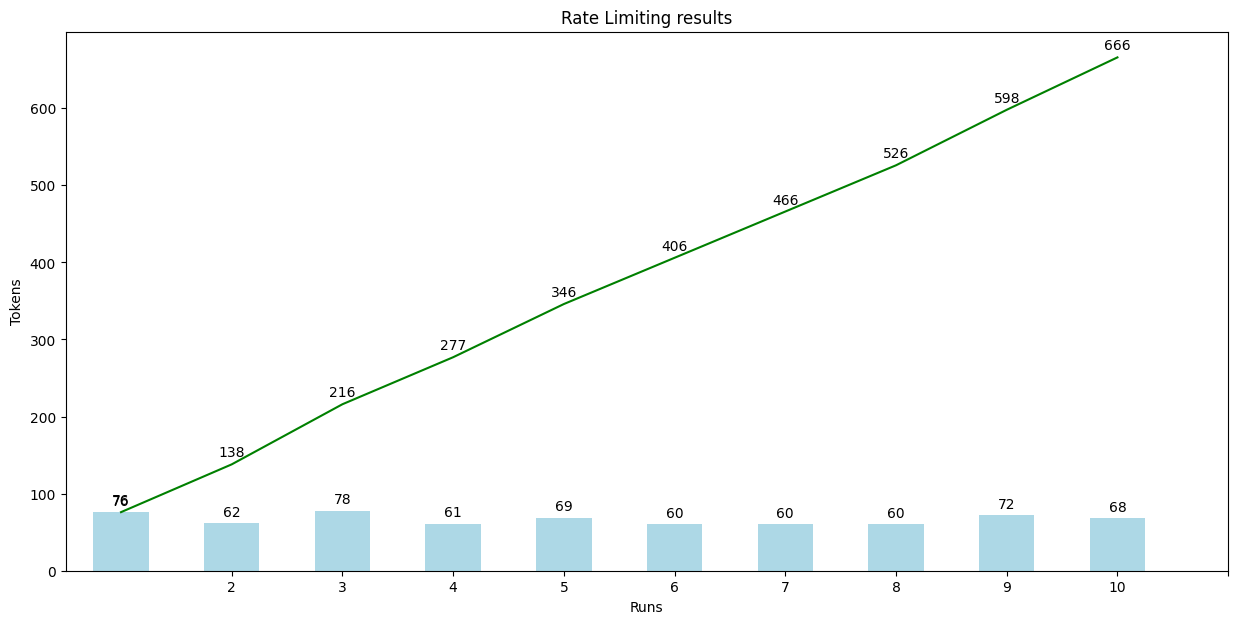

In [3]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else val, ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, str(int(val)), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()